# Homework 4

In [38]:
# import os
# if not os.path.exists('san_rafael'):
#     !wget -O san_rafael.zip https://www.dropbox.com/scl/fi/pyl1h8g56xdp74568aizj/san_rafael.zip?rlkey=kvfzhierbe938lt4vdgjx8mv6&dl=1
#     !unzip san_rafael.zip

In [39]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
print("GPUs detected:", gpus)

mixed_precision.set_global_policy('mixed_float16')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Loading Dataset and Preparing Train and Test Splits

In [40]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

base_dir = 'san_rafael'
image_dir = os.path.join(base_dir, 'image')
label_dir = os.path.join(base_dir, 'label')
height_dir = os.path.join(base_dir, 'height')

In [41]:
image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))
height_files = sorted(os.listdir(height_dir))

num_samples = len(image_files)

sample_img = np.array(Image.open(os.path.join(image_dir, image_files[0])))
H, W = sample_img.shape[:2]
if sample_img.ndim == 3:
    C = sample_img.shape[2]

In [42]:
images = np.zeros((num_samples, H, W, C), dtype=np.uint8)
labels = np.zeros((num_samples, H, W), dtype=np.uint8)
raw_heights = np.zeros((num_samples, H, W), dtype=np.float32)  # temporary raw heights

# load the images
for i, fname in enumerate(image_files):
    img_path = os.path.join(image_dir, fname)
    img_arr = np.array(Image.open(img_path))
    if C == 1 and img_arr.ndim == 2:
        images[i, :, :, 0] = img_arr
    else:
        images[i] = img_arr

# load the labels
for i, fname in enumerate(label_files):
    lbl_path = os.path.join(label_dir, fname)
    lbl_arr = np.array(Image.open(lbl_path))
    labels[i] = lbl_arr

# load the heights
for i, fname in enumerate(height_files):
    h_path = os.path.join(height_dir, fname)
    h_arr = np.array(Image.open(h_path)).astype(np.float32)
    raw_heights[i] = h_arr

# convert heights to float32 and normalize by maximum height
max_height_value = raw_heights.max()
heights = (raw_heights / max_height_value).astype(np.float32)

# del temporary raw heights to free memory
del raw_heights

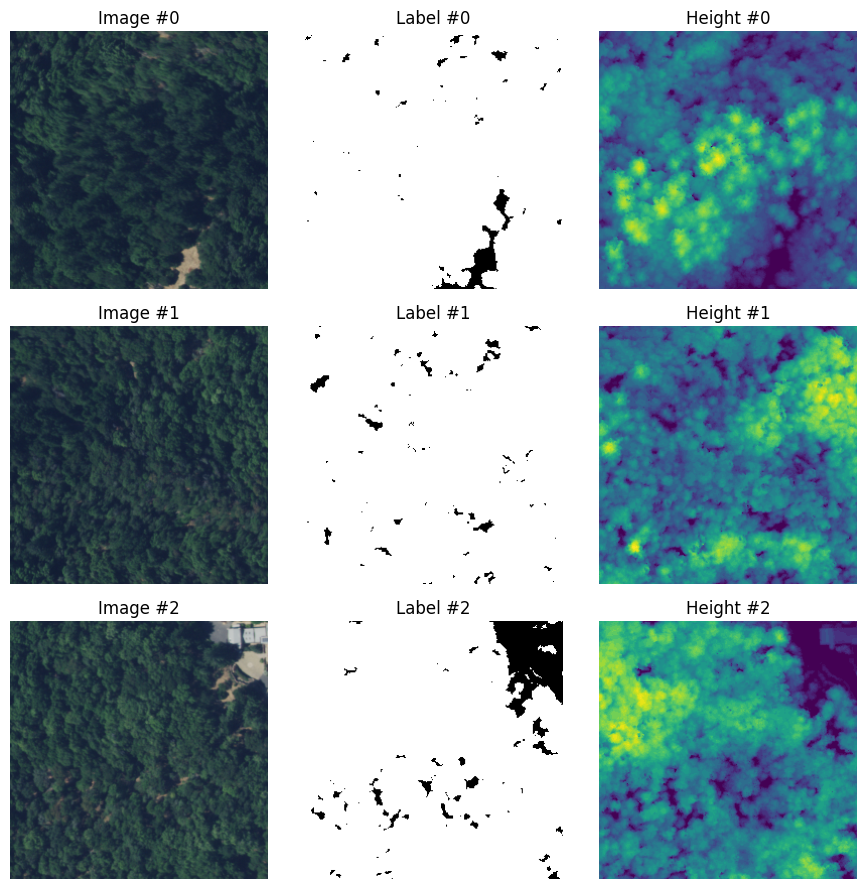

In [43]:
# showing some examples
num_examples_to_show = 3
fig, axes = plt.subplots(num_examples_to_show, 3, figsize=(9, 3 * num_examples_to_show))

for idx in range(num_examples_to_show):
    i = idx
    ax_img = axes[idx, 0]
    if C == 1:
        ax_img.imshow(images[i, :, :, 0], cmap='gray')
    else:
        ax_img.imshow(images[i])
    ax_img.set_title(f'Image #{i}')
    ax_img.axis('off')
    
    # plot label
    ax_lbl = axes[idx, 1]
    ax_lbl.imshow(labels[i], cmap='gray')
    ax_lbl.set_title(f'Label #{i}')
    ax_lbl.axis('off')

    # plot normalized height map
    ax_h = axes[idx, 2]
    ax_h.imshow(heights[i], cmap='viridis')
    ax_h.set_title(f'Height #{i}')
    ax_h.axis('off')

plt.tight_layout()
plt.show()

In [44]:
# split the dataset into training and validation sets (90% train, 10% test)
X_train, X_test, y_train, y_test, h_train, h_test = train_test_split(
    images, labels, heights,
    test_size=0.10,
    random_state=42,
    shuffle=True
)

# delete the full arrays to free memory
del images, labels, heights

### Creating the Classification CNN

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# expand dimensions for Keras compatibility
y_train_exp = np.expand_dims(y_train, axis=-1)
y_test_exp  = np.expand_dims(y_test,  axis=-1)

In [46]:
inputs = tf.keras.Input(shape=(256, 256, 3))

x = layers.Lambda(lambda x: x / 255.0 - 0.5)(inputs)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

outputs = layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [47]:
opt = optimizers.Adam(learning_rate=0.0004)
model.compile(optimizer=opt,
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_1 (Cast)                   │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 256, 256, 1)    │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
print("Using device:", tf.config.experimental.list_physical_devices())
history = model.fit(
    X_train,
    y_train_exp,
    validation_split=0.10,
    batch_size=32,
    epochs=10,
    verbose=True
)

Using device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 52s 483ms/step - accuracy: 0.7444 - loss: 0.5125 - val_accuracy: 0.8526 - val_loss: 0.3296
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 47s 459ms/step - accuracy: 0.8695 - loss: 0.3070 - val_accuracy: 0.8666 - val_loss: 0.3076
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 47s 456ms/step - accuracy: 0.8751 - loss: 0.2941 - val_accuracy: 0.8734 - val_loss: 0.3012
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 47s 461ms/step - accuracy: 0.8819 - loss: 0.2829 - val_accuracy: 0.8766 - val_loss: 0.2927
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 450ms/step - accuracy: 0.8838 - loss: 0.2787 - val_accuracy: 0.8789 - val_loss: 0.2892
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 446ms/step - accuracy: 0.8873 - loss: 0.2705 - val_accuracy: 0.8797 - val_loss: 0.2862
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 46s 451ms/step - accuracy: 

In [49]:
test_loss, test_acc = model.evaluate(X_test, y_test_exp, verbose=True)

print(f'Test accuracy: {test_acc:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.8963 - loss: 0.2517
Test accuracy: 0.8960


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step


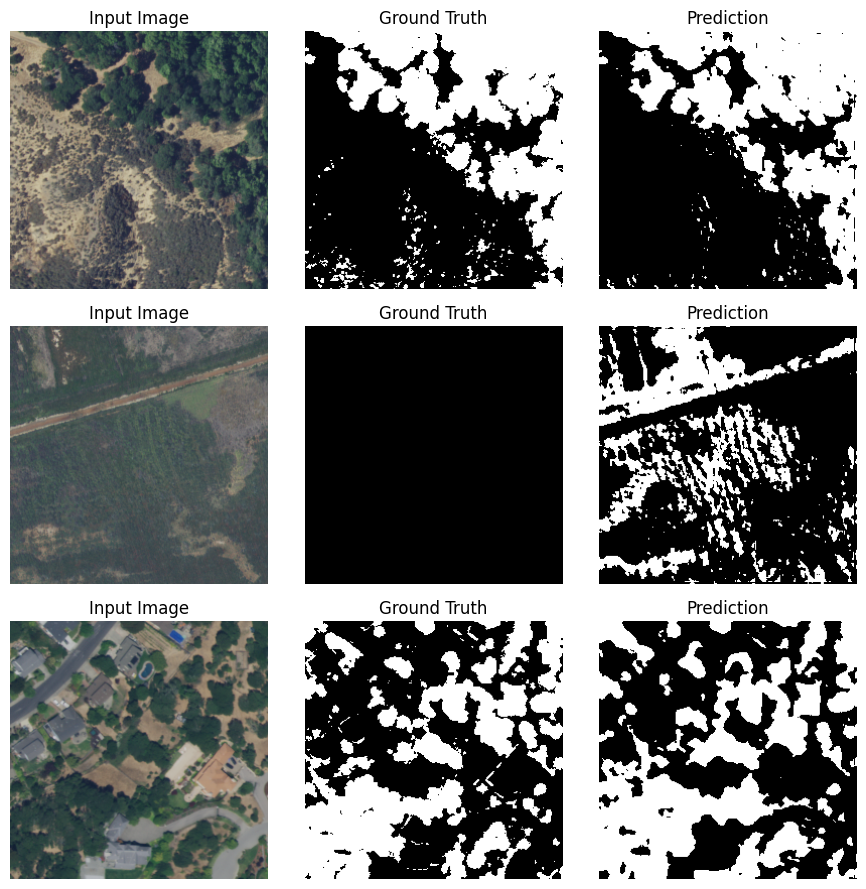

In [50]:
num_examples = 3
preds = model.predict(X_test[:num_examples])

fig, axes = plt.subplots(num_examples, 3, figsize=(9, 3 * num_examples))

for i in range(num_examples):
    # input image
    axes[i, 0].imshow(X_test[i].astype(np.uint8))
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')

    # ground truth label
    axes[i, 1].imshow(y_test[i], cmap='gray')
    axes[i, 1].set_title('Ground Truth')
    axes[i, 1].axis('off')

    # predicted mask with a threshold at 0.5
    pred_mask = (preds[i, :, :, 0] >= 0.5).astype(np.uint8)
    axes[i, 2].imshow(pred_mask, cmap='gray')
    axes[i, 2].set_title('Prediction')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

### Creating the Regression CNN

In [51]:
h_train_exp = np.expand_dims(h_train, axis=-1)
h_test_exp  = np.expand_dims(h_test, axis=-1)

In [52]:
inputs = tf.keras.Input(shape=(256, 256, 3))

x = layers.Lambda(lambda x: x / 255.0 - 0.5)(inputs)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)

outputs = layers.Conv2D(1, (1, 1), padding='same', activation='linear')(x)
model_reg = tf.keras.Model(inputs=inputs, outputs=outputs)

In [53]:
opt_reg = optimizers.Adam(learning_rate=0.0004)
model_reg.compile(optimizer=opt_reg,
                  loss='mean_absolute_error')

model_reg.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_2 (Cast)                   │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 256, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 256, 256, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 256, 256, 1)    │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,377 (364.75 KB)

 Trainable params: 93,377 (364.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
d

Using device: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 43s 411ms/step - loss: 0.0295 - val_loss: 0.0243
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 0.0252 - val_loss: 0.0238
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 0.0242 - val_loss: 0.0242
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 0.0240 - val_loss: 0.0230
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 0.0240 - val_loss: 0.0228
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 0.0239 - val_loss: 0.0226
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - loss: 0.0229 - val_loss: 0.0230
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - loss: 0.0227 - val_loss: 0.0232
Epoch 9/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/step - loss: 0.0233 - val_loss: 0.0222
Epoch 10/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 42s 405ms/s

In [55]:
test_mae = model_reg.evaluate(X_test, h_test_exp, verbose=True)

print(f'Test MAE: {test_mae:.4f}')

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0211
Test MAE: 0.0206


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


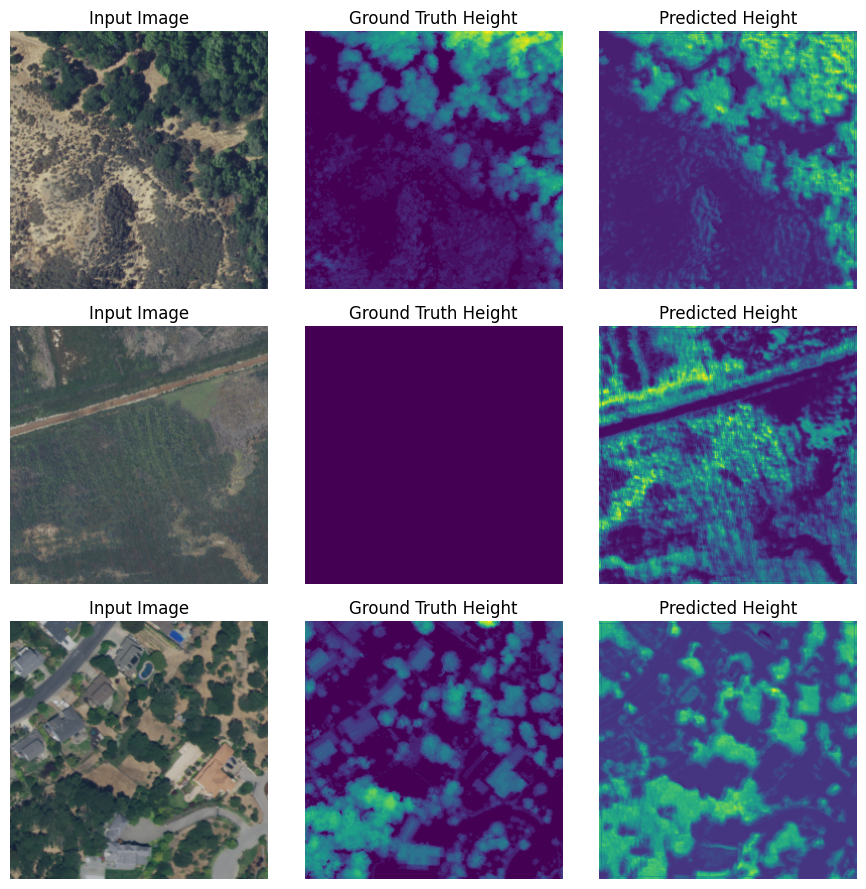

In [56]:
num_examples = 3
preds_h = model_reg.predict(X_test[:num_examples])

fig, axes = plt.subplots(num_examples, 3, figsize=(9, 3 * num_examples))

for i in range(num_examples):
    # input image
    axes[i, 0].imshow(X_test[i].astype(np.uint8))
    axes[i, 0].set_title('Input Image')
    axes[i, 0].axis('off')
    
    # ground truth normalized height map
    gt_height = h_test[i]
    axes[i, 1].imshow(gt_height, cmap='viridis')
    axes[i, 1].set_title('Ground Truth Height')
    axes[i, 1].axis('off')

    # predicted normalized height map
    pred_height = preds_h[i, :, :, 0]
    axes[i, 2].imshow(pred_height, cmap='viridis')
    axes[i, 2].set_title('Predicted Height')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()